# Predict Crimes in Vancouver - XGBoost

We compare XGBoost on four different models and tune hyperparameters on each:
1. Data without the `part_of_day` feature and without over-sampling.
2. Data without the `part_of_day` feature and with over-sampling.
3. Data with the `part_of_day` feature and without over-sampling.
4. Data with the `part_of_day` feature and with over-sampling.

## Research Sources
[1] Hossain, S., Abtahee, A., Kashem, I., Hoque, M.M., Sarker, I.H. (2020). Crime Prediction Using Spatio-Temporal Data. In: Chaubey, N., Parikh, S., Amin, K. (eds) Computing Science, Communication and Security. COMS2 2020. Communications in Computer and Information Science, vol 1235. Springer, Singapore. https://doi.org/10.1007/978-981-15-6648-6_22

[2] Rotaru, V., Huang, Y., Li, T. et al. Event-level prediction of urban crime reveals a signature of enforcement bias in US cities. Nat Hum Behav 6, 1056–1068 (2022). https://doi.org/10.1038/s41562-022-01372-0

[3] CSV to Shapefile with pyshp: https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/

[4] Machine Learning with Datetime Feature Engineering: Predicting Healthcare Appointment No-Shows: https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

[5] Fine tuning a classifier in scikit-learn: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

## Libraries and Functions

In [1]:
import pandas as pd
pd.options.display.max_columns = None  # display all dataframe columns in the notebook
import numpy as np
import csv

# models
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, plot_tree, export_graphviz
from xgboost import XGBClassifier

# transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Bayesian optimization over hyperparameters
from skopt.searchcv import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

# metrics
from sklearn.metrics import precision_recall_curve, roc_auc_score, balanced_accuracy_score, average_precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# visualize trees
from IPython.display import Image  
from six import StringIO
import pydotplus, graphviz

# over/under sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# pipeline
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline 

# display pipelines
from sklearn import set_config
set_config(display="diagram")

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)  # set standard figure size
%matplotlib inline

# suppress warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
## taken from [4]

# calculate specificity
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_actual, (y_pred >= thresh))
    accuracy = accuracy_score(y_actual, (y_pred >= thresh))
    recall = recall_score(y_actual, (y_pred >= thresh))
    average_precision = average_precision_score(y_actual, (y_pred >= thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = f1_score(y_actual, (y_pred >= thresh))
    print('ROC AUC: %.3f'%auc)
    print('Balanced accuracy: %.3f'%balanced_accuracy)
    print('Accuracy: %.3f'%accuracy)
    print('Recall: %.3f'%recall)
    print('Average precision: %.3f'%average_precision)
    print('Specificity: %.3f'%specificity)
    print('F1: %.3f'%f1)
    print(' ')

In [3]:
## taken from [5]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

## Model 1

Use the data without the `part_of_day` feature, which reduces the data size to a quarter.

In [5]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification_without_partofday.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,1
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,0


In [6]:
# data size
crime_df_full.shape

(1120116, 9)

In [7]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
crime             int64
dtype: object

In [8]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
crime                     int64
dtype: object

In [9]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [10]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(67665, 6)
(22555, 6)
(67665,)
(22555,)


In [11]:
## define variable types
nominal_cols = ['weekday','season']

# all variables
all_cols = list(X_train.columns)

In [12]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0))
    ]
)

# define hyperparameter search space
param_dict = {'xgb__n_estimators': Integer(5,500, prior='uniform'),
              'xgb__max_depth': Integer(2,20, prior='uniform'),
              'xgb__min_child_weight': Real(1e-4, 5e-1, prior='log-uniform'),
              'xgb__gamma': Real(0, 40, prior='uniform'),
              'xgb__reg_alpha': Real(1e-5, 1e2, prior='log-uniform'),
              'xgb__reg_lambda' : Real(1e-5, 1, prior='log-uniform'),
              'xgb__colsample_bytree': Real(0.5, 1, prior='uniform'),
              'xgb__subsample': Real(0.5, 1, prior='uniform'),
              'xgb__colsample_bylevel': Real(0.1, 1, prior='uniform'),
              'xgb__learning_rate': Real(5e-3, 3e-1, prior='log-uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [25]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.5256303993750098

In [26]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('xgb__colsample_bylevel', 0.7998785306772966),
             ('xgb__colsample_bytree', 0.7265886015288889),
             ('xgb__gamma', 10.335290775084683),
             ('xgb__learning_rate', 0.06595221526744172),
             ('xgb__max_depth', 7),
             ('xgb__min_child_weight', 0.004780403513516732),
             ('xgb__n_estimators', 500),
             ('xgb__reg_alpha', 0.3054207364398588),
             ('xgb__reg_lambda', 4.0548663381821676e-05),
             ('xgb__subsample', 0.7323928062084547)])

In [30]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0,
                             colsample_bylevel=0.7998785306772966, colsample_bytree=0.7265886015288889,
                              gamma=10.335290775084683, learning_rate=0.06595221526744172, max_depth=7,
                              min_child_weight=0.004780403513516732, n_estimators=500,
                              reg_alpha=0.3054207364398588, reg_lambda=4.0548663381821676e-05,
                              subsample=0.7323928062084547))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'season'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.7998785306772966,
                               colsample_bynode=1,
                               colsample_bytree=0.7265886015288889,
                               gamma=10.3...
                               max_delta_step=0, max_depth=7,
                               min_child_weight=0.004780403513516732,
                               missing=nan, monotone_constraints='()',
                               n_estimators=500, n_jobs=7, nthread=7,
                               num_parallel_tree=1, random_state=94,
                               reg_alpha=0.3054207364398588,
                               reg_lambda=4.0548663381821676e-05,
                               scale_pos_weight=1, seed=94,
                               subsample=0.7323928062084547,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

In [31]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

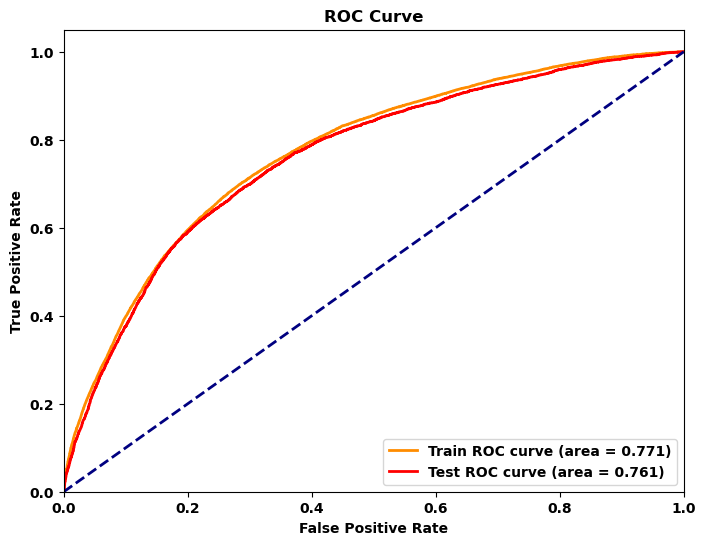

In [32]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color="darkorange", lw=lw, label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(fpr_test, tpr_test, color="red", lw=lw, label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [33]:
# standard threshold
thresh=0.5

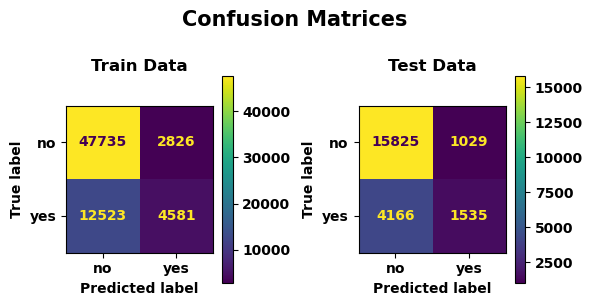

In [34]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [35]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.771
Balanced accuracy: 0.606
Accuracy: 0.773
Recall: 0.268
Average precision: 0.351
Specificity: 0.944
F1: 0.374
 


In [36]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.604
Accuracy: 0.770
Recall: 0.269
Average precision: 0.346
Specificity: 0.939
F1: 0.371
 


### Threshold Tuning, based on

#### F1 Score

In [37]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [38]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [39]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.312, F-score=0.544


In [40]:
# set threshold
thresh = thresholds[ix]
thresh

0.312

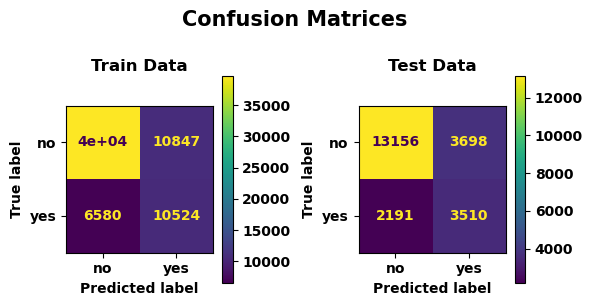

In [41]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [42]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.771
Balanced accuracy: 0.700
Accuracy: 0.742
Recall: 0.615
Average precision: 0.400
Specificity: 0.785
F1: 0.547
 


In [43]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.698
Accuracy: 0.739
Recall: 0.616
Average precision: 0.397
Specificity: 0.781
F1: 0.544
 


#### ROC AUC Curve

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [45]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.245926


In [46]:
# set threshold
thresh = best_thresh
thresh

0.24592589

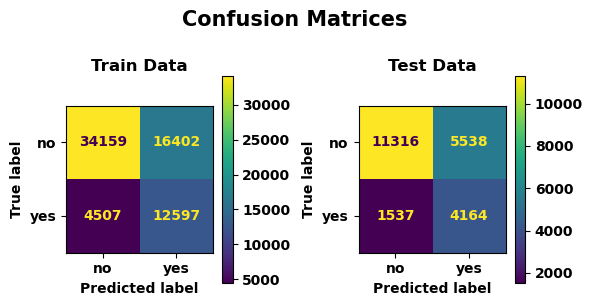

In [47]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [48]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.771
Balanced accuracy: 0.706
Accuracy: 0.691
Recall: 0.736
Average precision: 0.387
Specificity: 0.676
F1: 0.546
 


In [49]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.701
Accuracy: 0.686
Recall: 0.730
Average precision: 0.382
Specificity: 0.671
F1: 0.541
 


#### Precision-Recall Curve

In [50]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

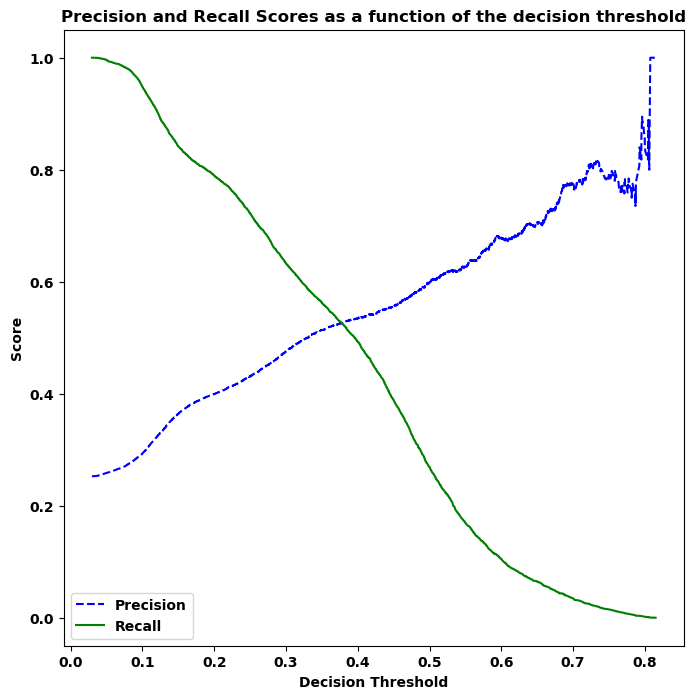

In [51]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [52]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.37743482

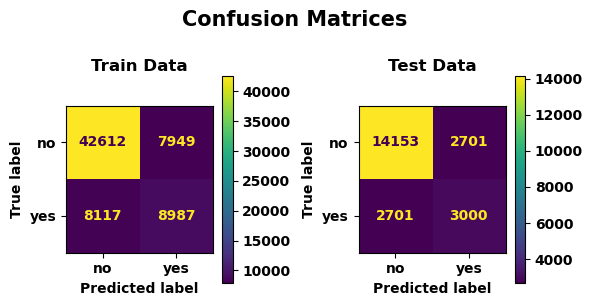

In [53]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [54]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.771
Balanced accuracy: 0.684
Accuracy: 0.763
Recall: 0.525
Average precision: 0.399
Specificity: 0.843
F1: 0.528
 


In [55]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.683
Accuracy: 0.760
Recall: 0.526
Average precision: 0.397
Specificity: 0.840
F1: 0.526
 


The threshold 0.25 yields the highest recall (0.730) and balanced accuracy (0.701).

The threshold 0.31 yields the highest average precision (0.397) and F1 score (0.544).

The threshold 0.5 yields the highest accuracy (0.770) and specificity (0.939).

### Feature Importance

In [56]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

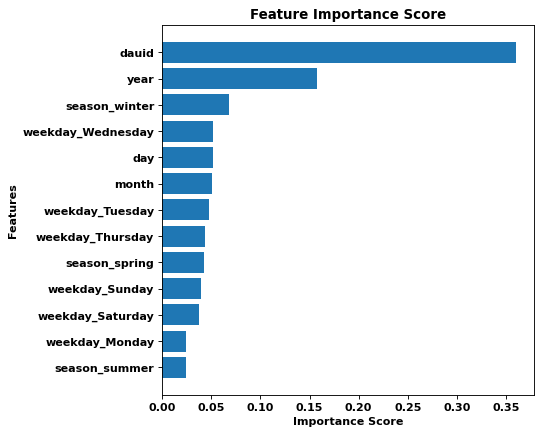

In [57]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year` is the second most important feature.
- `day`, `month`, `season`, and `weekday` are not very important.

## Model 2

Model 1 with over-sampling.

In [58]:
from imblearn.pipeline import Pipeline

In [59]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification_without_partofday.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,1
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,0


In [60]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
crime                     int64
dtype: object

In [61]:
# set target column
target_col = 'crime'

In [62]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(67665, 6)
(22555, 6)
(67665,)
(22555,)


In [63]:
## define variable types
nominal_cols = ['weekday','season']

# all variables
all_cols = list(X_train.columns)

In [64]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [65]:
# class inbalance
inbalance = y_train.value_counts()[1]/y_train.value_counts()[0]
inbalance

0.338284448487965

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE()),
        #('under', RandomUnderSampler()),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0))
    ]
)

# define hyperparameter search space
param_dict = {'xgb__n_estimators': Integer(5,500, prior='uniform'),
              'xgb__max_depth': Integer(2,20, prior='uniform'),
              'xgb__min_child_weight': Real(1e-4, 5e-1, prior='log-uniform'),
              'xgb__gamma': Real(0, 40, prior='uniform'),
              'xgb__reg_alpha': Real(1e-5, 1e2, prior='log-uniform'),
              'xgb__reg_lambda' : Real(1e-5, 1, prior='log-uniform'),
              'xgb__colsample_bytree': Real(0.5, 1, prior='uniform'),
              'xgb__subsample': Real(0.5, 1, prior='uniform'),
              'xgb__colsample_bylevel': Real(0.1, 1, prior='uniform'),
              'xgb__learning_rate': Real(5e-3, 3e-1, prior='log-uniform'),
              'over__sampling_strategy': Real(0.35, 1., prior='uniform')}
              #'under__sampling_strategy': Real(0.3, 0.6, prior='uniform')}


# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [69]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.5240141617686431

In [70]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('over__sampling_strategy', 0.4875008779680794),
             ('xgb__colsample_bylevel', 0.790260137029048),
             ('xgb__colsample_bytree', 0.6415099001467015),
             ('xgb__gamma', 8.008888840700202),
             ('xgb__learning_rate', 0.010063566718229871),
             ('xgb__max_depth', 13),
             ('xgb__min_child_weight', 0.03283292641186251),
             ('xgb__n_estimators', 315),
             ('xgb__reg_alpha', 0.0013269758321198715),
             ('xgb__reg_lambda', 0.0003666980223241234),
             ('xgb__subsample', 0.6768488934858763)])

In [71]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE(sampling_strategy=0.4875008779680794)),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0, colsample_bylevel=0.790260137029048,
                              colsample_bytree=0.6415099001467015, gamma=8.008888840700202,
                              learning_rate=0.010063566718229871, max_depth=13,
                              min_child_weight=0.03283292641186251, n_estimators=315,
                              reg_alpha=0.0013269758321198715, reg_lambda=0.0003666980223241234,
                              subsample=0.6768488934858763))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'season'])])),
                ('over', SMOTE(sampling_strategy=0.4875008779680794)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.790260137029048,
                               colsample_byn...
                               max_delta_step=0, max_depth=13,
                               min_child_weight=0.03283292641186251,
                               missing=nan, monotone_constraints='()',
                               n_estimators=315, n_jobs=7, nthread=7,
                               num_parallel_tree=1, random_state=94,
                               reg_alpha=0.0013269758321198715,
                               reg_lambda=0.0003666980223241234,
                               scale_pos_weight=1, seed=94,
                               subsample=0.6768488934858763,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

In [72]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

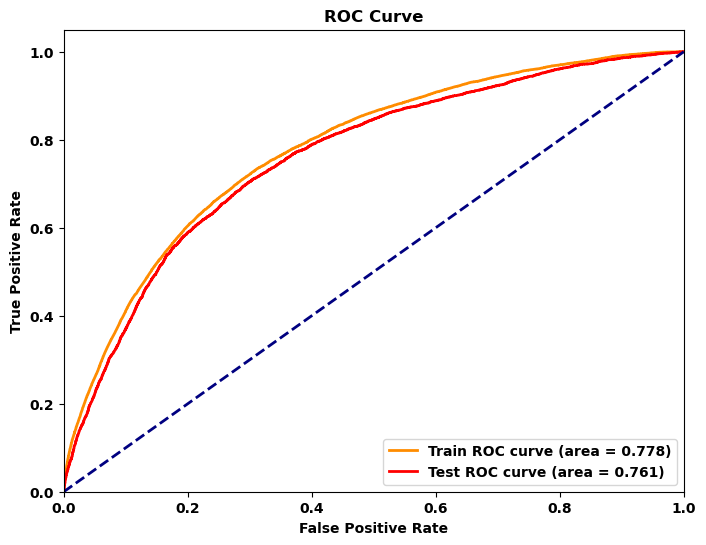

In [73]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color="darkorange", lw=lw, label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(fpr_test, tpr_test, color="red", lw=lw, label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [74]:
# standard threshold
thresh=0.5

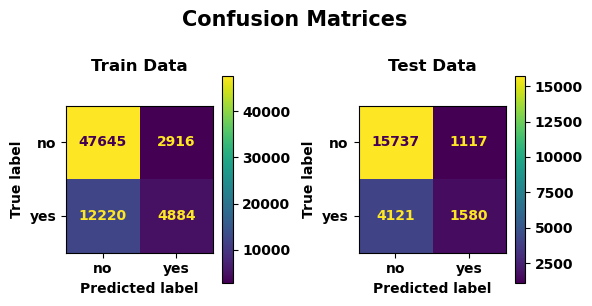

In [75]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [76]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.778
Balanced accuracy: 0.614
Accuracy: 0.776
Recall: 0.286
Average precision: 0.359
Specificity: 0.942
F1: 0.392
 


In [77]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.605
Accuracy: 0.768
Recall: 0.277
Average precision: 0.345
Specificity: 0.934
F1: 0.376
 


### Threshold Tuning, based on

#### F1 Score

In [78]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [79]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [80]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.294, F-score=0.545


In [81]:
# set threshold
thresh = thresholds[ix]
thresh

0.294

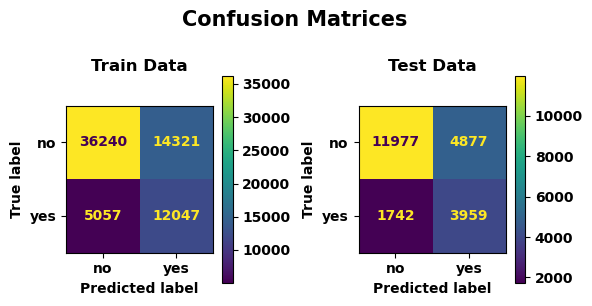

In [82]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [83]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.778
Balanced accuracy: 0.711
Accuracy: 0.714
Recall: 0.704
Average precision: 0.397
Specificity: 0.717
F1: 0.554
 


In [84]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.703
Accuracy: 0.707
Recall: 0.694
Average precision: 0.388
Specificity: 0.711
F1: 0.545
 


#### ROC AUC Curve

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [86]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.290867


In [87]:
# set threshold
thresh = best_thresh
thresh

0.29086652

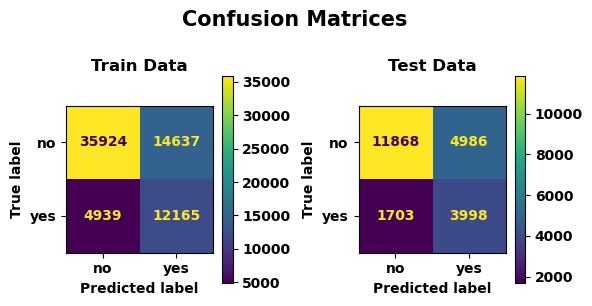

In [88]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [89]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.778
Balanced accuracy: 0.711
Accuracy: 0.711
Recall: 0.711
Average precision: 0.396
Specificity: 0.711
F1: 0.554
 


In [90]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.703
Accuracy: 0.703
Recall: 0.701
Average precision: 0.388
Specificity: 0.704
F1: 0.545
 


#### Precision-Recall Curve

In [91]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

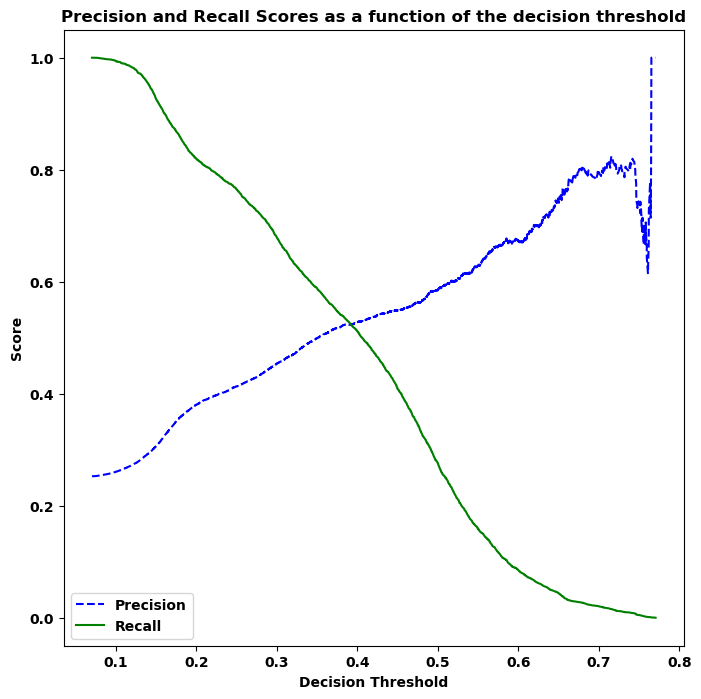

In [92]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [93]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.39221478

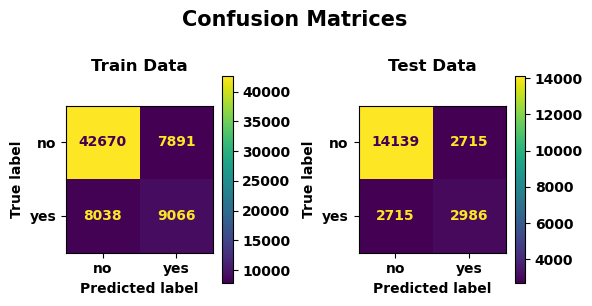

In [94]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [95]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.778
Balanced accuracy: 0.687
Accuracy: 0.765
Recall: 0.530
Average precision: 0.402
Specificity: 0.844
F1: 0.532
 


In [96]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.761
Balanced accuracy: 0.681
Accuracy: 0.759
Recall: 0.524
Average precision: 0.395
Specificity: 0.839
F1: 0.524
 


The threshold 0.29 yields the highest recall (0.701), balanced accuracy (0.703), and F1 score (0.545).

The threshold 0.39 yields the highest average precision (0.395).

The threshold 0.5 yields the highest accuracy (0.768) and specificity (0.934).

### Feature Importance

In [97]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

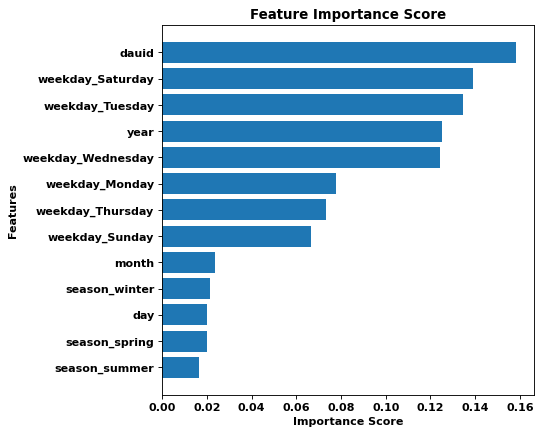

In [98]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is the most important feature, followed by `weekday` and `year`.
- `day`, `month`, and `season` are not very important.

## Model 3

Use the data with the `part_of_day` feature, which increases the data size by a factor of four.

In [100]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,part_of_day,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,early morning,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,early morning,0
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,early morning,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,early morning,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,early morning,0


In [101]:
# data size
crime_df_full.shape

(4480464, 10)

In [102]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
part_of_day      object
crime             int64
dtype: object

In [103]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
part_of_day              object
crime                     int64
dtype: object

In [104]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [105]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(270660, 7)
(90220, 7)
(270660,)
(90220,)


In [106]:
## define variable types

# nominal variables
nominal_cols = ['weekday','part_of_day','season']

# all variables
all_cols = list(X_train.columns)

In [107]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0))
    ]
)

# define hyperparameter search space
param_dict = {'xgb__n_estimators': Integer(5,500, prior='uniform'),
              'xgb__max_depth': Integer(2,20, prior='uniform'),
              'xgb__min_child_weight': Real(1e-4, 5e-1, prior='log-uniform'),
              'xgb__gamma': Real(0, 40, prior='uniform'),
              'xgb__reg_alpha': Real(1e-5, 1e2, prior='log-uniform'),
              'xgb__reg_lambda' : Real(1e-5, 1, prior='log-uniform'),
              'xgb__colsample_bytree': Real(0.5, 1, prior='uniform'),
              'xgb__subsample': Real(0.5, 1, prior='uniform'),
              'xgb__colsample_bylevel': Real(0.1, 1, prior='uniform'),
              'xgb__learning_rate': Real(5e-3, 3e-1, prior='log-uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

The score seems to be basically the same low score for all seen combinations. The model is bad.

In [109]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.2515067893880307

In [110]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('xgb__colsample_bylevel', 0.8168421730860463),
             ('xgb__colsample_bytree', 0.6409045011263401),
             ('xgb__gamma', 2.054663359660836),
             ('xgb__learning_rate', 0.06014519593995283),
             ('xgb__max_depth', 19),
             ('xgb__min_child_weight', 0.17754754327580097),
             ('xgb__n_estimators', 386),
             ('xgb__reg_alpha', 17.30780020426697),
             ('xgb__reg_lambda', 0.6334536189049887),
             ('xgb__subsample', 0.8599837514568531)])

In [111]:
# train a model on the entire train set
pipe = pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0, 
                             colsample_bylevel=0.8168421730860463, colsample_bytree=0.6409045011263401,
                              gamma=2.054663359660836, learning_rate=0.06014519593995283, max_depth=19,
                              min_child_weight=0.17754754327580097, n_estimators=386, 
                              reg_alpha=17.30780020426697, reg_lambda=0.6334536189049887,
                              subsample=0.8599837514568531))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'part_of_day',
                                                   'season'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.8168421730860463,
                               colsample_bynode=1,
                               colsample_bytree=0.6409045011263...
                               learning_rate=0.06014519593995283,
                               max_delta_step=0, max_depth=19,
                               min_child_weight=0.17754754327580097,
                               missing=nan, monotone_constraints='()',
                               n_estimators=386, n_jobs=7, nthread=7,
                               num_parallel_tree=1, random_state=94,
                               reg_alpha=17.30780020426697,
                               reg_lambda=0.6334536189049887,
                               scale_pos_weight=1, seed=94,
                               subsample=0.8599837514568531,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

In [112]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

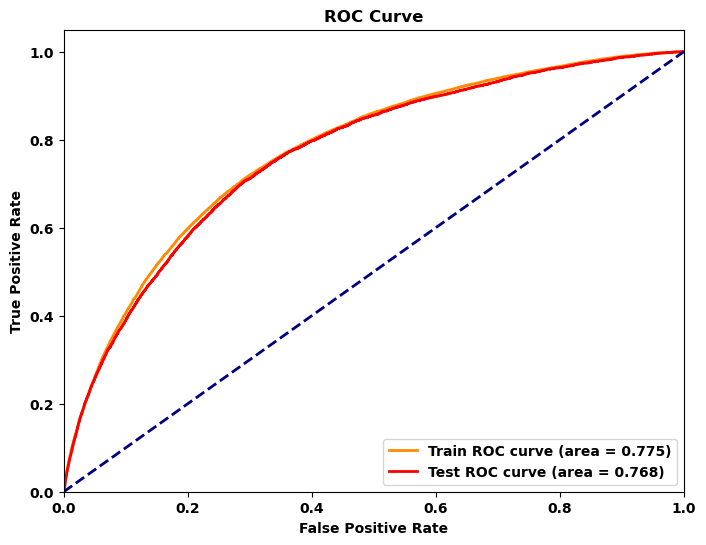

In [113]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(
    fpr_train,
    tpr_train,
    color="darkorange",
    lw=lw,
    label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="red",
    lw=lw,
    label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [114]:
# standard threshold
thresh=0.5

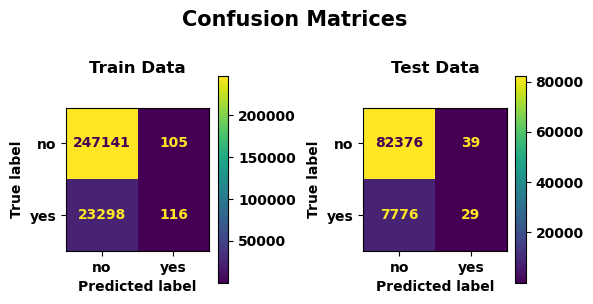

In [115]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [116]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.502
Accuracy: 0.914
Recall: 0.005
Average precision: 0.089
Specificity: 1.000
F1: 0.010
 


In [117]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.502
Accuracy: 0.913
Recall: 0.004
Average precision: 0.088
Specificity: 1.000
F1: 0.007
 


### Threshold Tuning, based on

#### F1 Score

In [118]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [119]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [120]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.164, F-score=0.324


In [121]:
# set threshold
thresh = thresholds[ix]
thresh

0.164

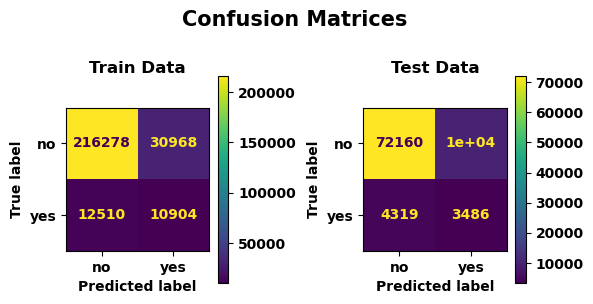

In [122]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [123]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.670
Accuracy: 0.839
Recall: 0.466
Average precision: 0.167
Specificity: 0.875
F1: 0.334
 


In [124]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.661
Accuracy: 0.838
Recall: 0.447
Average precision: 0.161
Specificity: 0.876
F1: 0.324
 


#### ROC AUC Curve

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [126]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.087434


In [127]:
# set threshold
thresh = best_thresh
thresh

0.08743369

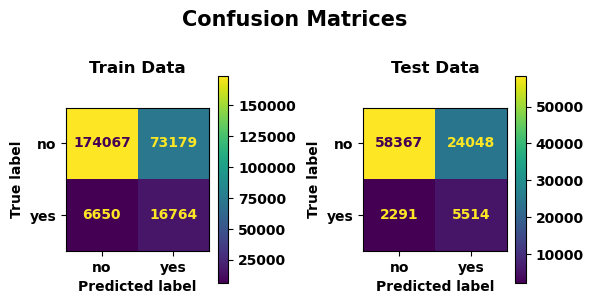

In [128]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [129]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.710
Accuracy: 0.705
Recall: 0.716
Average precision: 0.158
Specificity: 0.704
F1: 0.296
 


In [130]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.707
Accuracy: 0.708
Recall: 0.706
Average precision: 0.157
Specificity: 0.708
F1: 0.295
 


#### Precision-Recall Curve

In [131]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

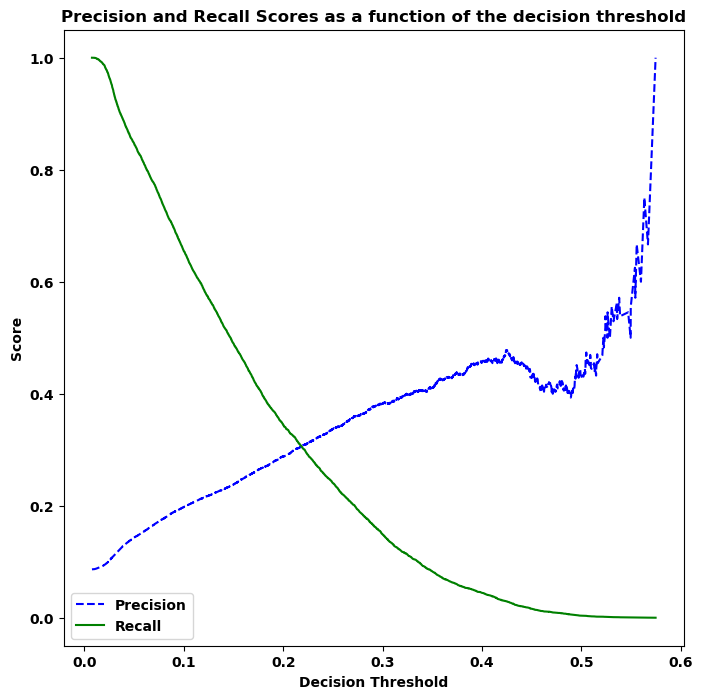

In [132]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [133]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.21824855

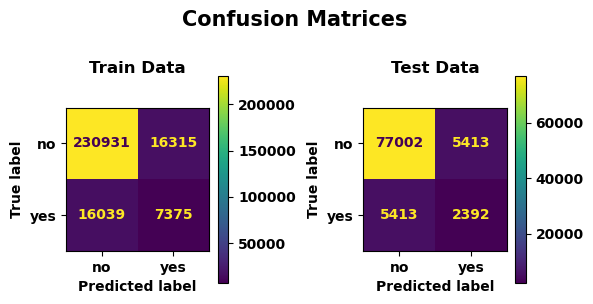

In [134]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [135]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.624
Accuracy: 0.880
Recall: 0.315
Average precision: 0.157
Specificity: 0.934
F1: 0.313
 


In [136]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.620
Accuracy: 0.880
Recall: 0.306
Average precision: 0.154
Specificity: 0.934
F1: 0.306
 


The threshold 0.5 can barely predict crimes, hence we will exclude it.

The threshold 0.09 yields the highest recall (0.706) and balanced accuracy (0.707).

The threshold 0.16 yields the highest average precision (0.161) and F1 score (0.324).

The threshold 0.22 yields the highest accuracy (0.880) and specificity (0.934).

### Feature Importance

In [137]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'part_of_day_early morning',
 'part_of_day_late morning',
 'part_of_day_night',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

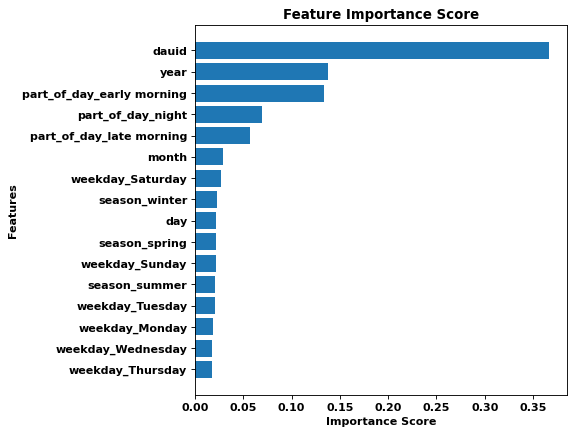

In [138]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year` and  `part_of_day` are the next two most important features.
- `day`, `month`, `season`, and `weekday` are not very important.

## Model 4

Model 3 with over-sampling.

In [4]:
from imblearn.pipeline import Pipeline

In [5]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,part_of_day,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,early morning,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,early morning,0
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,early morning,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,early morning,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,early morning,0


In [6]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
part_of_day              object
crime                     int64
dtype: object

In [7]:
# set target column
target_col = 'crime'

In [8]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(270660, 7)
(90220, 7)
(270660,)
(90220,)


In [9]:
## define variable types

# nominal variables
nominal_cols = ['weekday','part_of_day','season']

# all variables
all_cols = list(X_train.columns)

In [10]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [11]:
# class inbalance
inbalance = y_train.value_counts()[1]/y_train.value_counts()[0]
inbalance

0.09469920645834513

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE()),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0))
    ]
)

# define hyperparameter search space
param_dict = {'xgb__n_estimators': Integer(5,500, prior='uniform'),
              'xgb__max_depth': Integer(2,20, prior='uniform'),
              'xgb__min_child_weight': Real(1e-4, 5e-1, prior='log-uniform'),
              'xgb__gamma': Real(0, 40, prior='uniform'),
              'xgb__reg_alpha': Real(1e-5, 1e2, prior='log-uniform'),
              'xgb__reg_lambda' : Real(1e-5, 1, prior='log-uniform'),
              'xgb__colsample_bytree': Real(0.5, 1, prior='uniform'),
              'xgb__subsample': Real(0.5, 1, prior='uniform'),
              'xgb__colsample_bylevel': Real(0.1, 1, prior='uniform'),
              'xgb__learning_rate': Real(5e-3, 3e-1, prior='log-uniform'),
              'over__sampling_strategy': Real(0.1, 1., prior='uniform')}
              #'under__sampling_strategy': Real(0.3, 0.6, prior='uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [148]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.25110945233128007

In [149]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('over__sampling_strategy', 0.1),
             ('xgb__colsample_bylevel', 1.0),
             ('xgb__colsample_bytree', 0.9703866041327824),
             ('xgb__gamma', 17.197973153945096),
             ('xgb__learning_rate', 0.06897288747542465),
             ('xgb__max_depth', 13),
             ('xgb__min_child_weight', 0.0009509955178490922),
             ('xgb__n_estimators', 430),
             ('xgb__reg_alpha', 0.058466911627753373),
             ('xgb__reg_lambda', 0.066035171995702),
             ('xgb__subsample', 0.7048752176921712)])

In [12]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE(sampling_strategy=0.1)),
        ('xgb', XGBClassifier(nthread=7, seed=94, verbosity=0, colsample_bylevel=1.0, colsample_bytree=0.9703866041327824,
                              gamma=17.197973153945096, learning_rate=0.06897288747542465, max_depth=13,
                              min_child_weight=0.0009509955178490922, n_estimators=430, reg_alpha=0.058466911627753373,
                              reg_lambda=0.066035171995702, subsample=0.7048752176921712))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'part_of_day',
                                                   'season'])])),
                ('over', SMOTE(sampling_strategy=0.1)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1.0, colsample_byn...
                               gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.06897288747542465, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=13, max_leaves=0,
                               min_child_weight=0.0009509955178490922,
                               missing=nan, monotone_constraints='()',
                               n_estimators=430, n_jobs=7, nthread=7,
                               num_parallel_tree=1, predictor='auto', ...))])

In [13]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

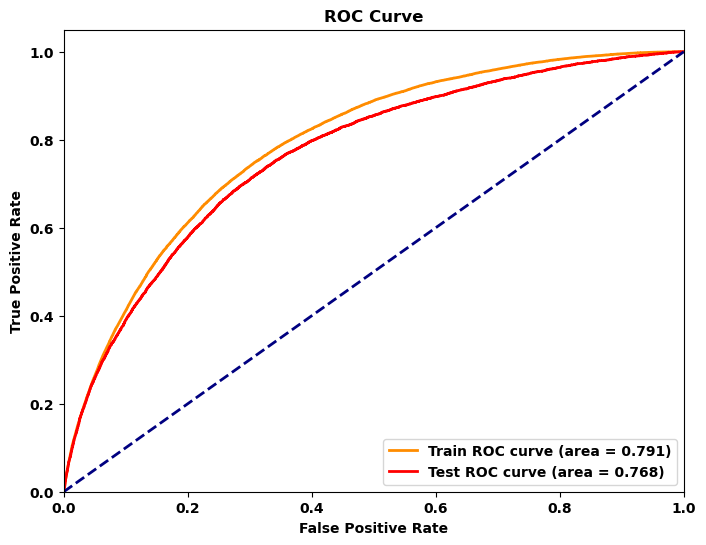

In [14]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(
    fpr_train,
    tpr_train,
    color="darkorange",
    lw=lw,
    label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="red",
    lw=lw,
    label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [15]:
# standard threshold
thresh=0.5

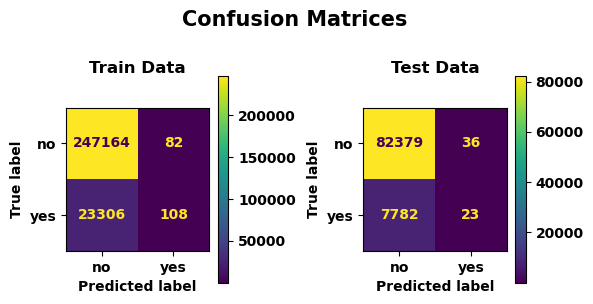

In [16]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [17]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.791
Balanced accuracy: 0.502
Accuracy: 0.914
Recall: 0.005
Average precision: 0.089
Specificity: 1.000
F1: 0.009
 


In [18]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.501
Accuracy: 0.913
Recall: 0.003
Average precision: 0.087
Specificity: 1.000
F1: 0.006
 


### Threshold Tuning, based on

#### F1 Score

In [19]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [20]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [21]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.171, F-score=0.321


In [22]:
# set threshold
thresh = thresholds[ix]
thresh

0.171

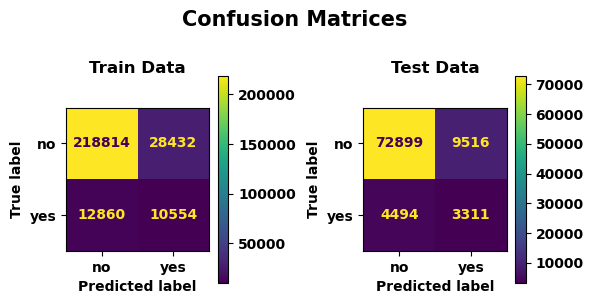

In [23]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [24]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.791
Balanced accuracy: 0.668
Accuracy: 0.847
Recall: 0.451
Average precision: 0.170
Specificity: 0.885
F1: 0.338
 


In [25]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.654
Accuracy: 0.845
Recall: 0.424
Average precision: 0.159
Specificity: 0.885
F1: 0.321
 


#### ROC AUC Curve

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [27]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.080655


In [28]:
# set threshold
thresh = best_thresh
thresh

0.08065452

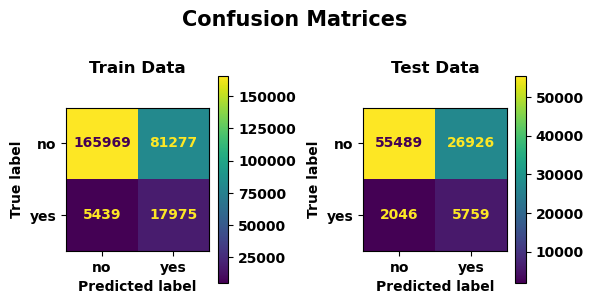

In [29]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [30]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.791
Balanced accuracy: 0.719
Accuracy: 0.680
Recall: 0.768
Average precision: 0.159
Specificity: 0.671
F1: 0.293
 


In [31]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.706
Accuracy: 0.679
Recall: 0.738
Average precision: 0.153
Specificity: 0.673
F1: 0.284
 


#### Precision-Recall Curve

In [32]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

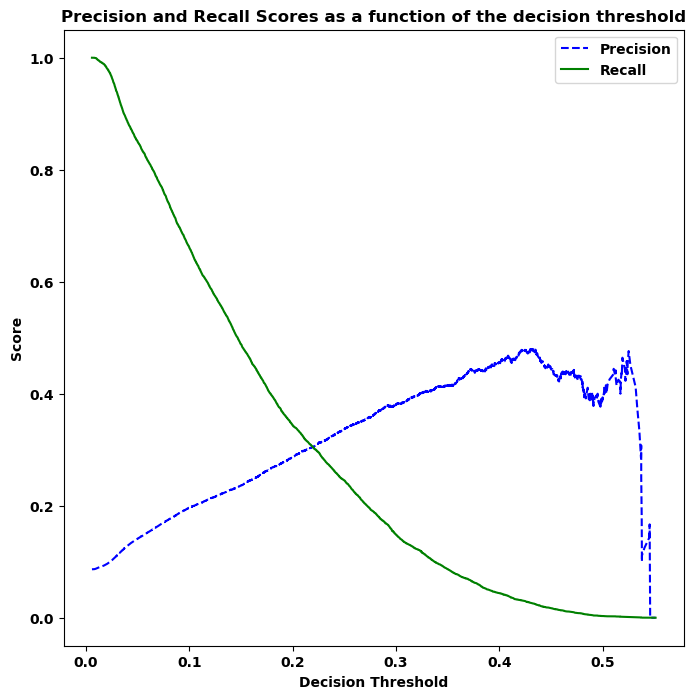

In [33]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [34]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.21968922

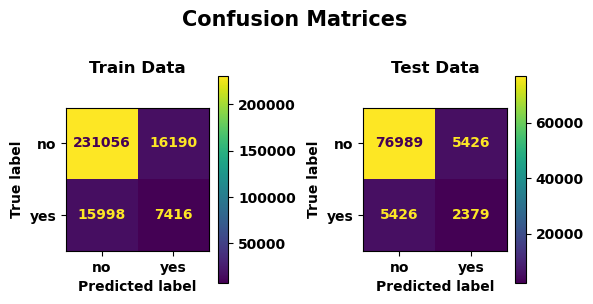

In [35]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [36]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.791
Balanced accuracy: 0.626
Accuracy: 0.881
Recall: 0.317
Average precision: 0.159
Specificity: 0.935
F1: 0.315
 


In [37]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.768
Balanced accuracy: 0.619
Accuracy: 0.880
Recall: 0.305
Average precision: 0.153
Specificity: 0.934
F1: 0.305
 


The threshold 0.5 can barely predict crimes, hence we will exclude it.

The threshold 0.08 yields the highest recall (0.738) and balanced accuracy (0.706).

The threshold 0.17 yields the highest F1 score (0.321) and average precision (0.159).

The threshold 0.22 yields the highest accuracy (0.880) and specificity (0.934).

### Feature Importance

In [38]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'part_of_day_early morning',
 'part_of_day_late morning',
 'part_of_day_night',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

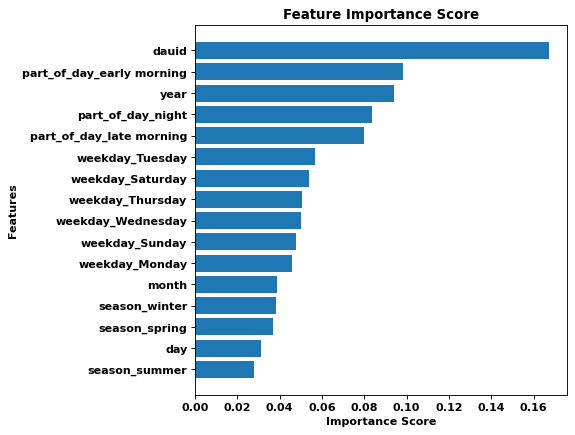

In [39]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year`, `day`, `month`, and `part_of_day` have much lower importance.
- `season` and `weekday` are not very important.

## Results

- We choose to predict crime in the `Central Business District` as it has by far the highest amount of reported crimes.


- We compared XGBoost on four different models and tuned hyperparameters on each:
    1. Data without the `part_of_day` feature and without over-sampling.
    2. Data without the `part_of_day` feature and with over-sampling.
    3. Data with the `part_of_day` feature and without over-sampling.
    4. Data with the `part_of_day` feature and with over-sampling.
    

- Model 1 is the best model with the following regard:
    - The threshold 0.31 yields the highest average precision (0.397).
    - The threshold 0.5 yields the highest specificity (0.939).
    
    
- Model 2 is the best model with the following regard:
    - The threshold 0.29 yields the highest F1 score (0.545).
    
    
- Model 3 is the best model with the following regard:
    - The threshold 0.09 yields the highest balanced accuracy (0.707).
    
    
- Model 4 is the best model with the following regard:
    - The threshold 0.08 yields the highest recall (0.738).
    
    
- Model 3 and 4 are the best models with the following regard:
    - The threshold 0.22 yields the highest accuracy (0.880).
    - They yield the higest ROC AUC score (0.768).
    

- The dissemination block is the most important feature. Year is the second most important feature. Weekday, day, month, and the part of the day have quite lower importance. Season is not very important.

## Next Steps
In the future, we plan to:
- use time series analysis to determine long-term changes and seasonal components of crime
- analyze over-/under-sampling
- incorporate the location of police stations
- incorporate demographic, social, and economic neighborhood characteristics